# Steganography via Least Squares

> *Numerical Optimization and Large Scale Linear Algebra*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

In steganography, a secret message is embedded in an image in such a way that the image looks the same, but an accomplice can decode the message. In this exercise we explore a simple approach to steganography that relies on constrained least squares. The secret message is given by a $k$-vector $s$ with entries that are all either $+1$ or $−1$ (i.e., it is a Boolean vector). The original image is given by the $n$-vector $x$, where $n$ is usually much larger than $k$. We send (or publish or transmit) the modified message $x+z$, where $z$ is an $n$-vector of modifications. We would like $z$ to be small, so that the original image $x$ and the modified one $x+z$ look (almost) the same. Our accomplice decodes the message $s$ by multiplying the modified image by a $k \times n$ matrix $D$, which yields the $k$-vector $y = D(x + z)$. The message is then decoded as $\hat{s}=sign(y)$. (We write $\hat{s}$ to show that it is an estimate, and might not be the same as the original). The matrix $D$ must have linearly independent rows, but otherwise is arbitrary.

**(a) - Encoding via least norm.**<br>Let $\alpha$ be a positive constant. We choose $z$ to minimize $\|z\|^{2}$ subject to $D(x+z)=\alpha s$ (This guarantees that the decoded message is correct, i.e., $\hat{s}=s$).

**(b) - Complexity.**<br>What is the complexity of encoding a secret message in an image? (You can assume that the $D^{†}$ is already computed and saved.) What is the complexity of decoding the secret message? About how long would each of these take with a computer capable of carrying out $1$ Gflop/s, for $k = 128$ and $n = 512^{2} = 262144$ (a $512 \times 512$ image)?

**(c) - Try it out.**<br>Choose an image $x$, with entries between $0$ (black) and $1$ (white), and a secret message $s$ with $k$ small compared to $n$, for example, $k = 128$ for a $512 \times 512$ image. (This corresponds to $16$ bytes, which can encode $16$ characters, i.e., letters, numbers, or punctuation marks.) Choose the entries of $D$ randomly, and compute $D^{†}$. The modified image $x+z$ may have entries outside the range $[0, 1]$. We replace any negative values in the modified image with zero, and any values greater than one with one. Adjust $\alpha$ until the original and modified images look the same, but the secret message is still decoded correctly. (If $α$ is too small, the clipping of the modified image values, or the round-off errors that occur in the computations, can lead to decoding error, i.e., $\hat{s}\neq{s}$. If $\alpha$ is too large, the modification will be visually apparent.) Once you’ve chosen $\alpha$, send several different secret messages embedded in several different original images.

> [***Introduction to Applied Linear Algebra:*** *Vectors, Matrices, and Least Squares*](https://github.com/sapaladas/msc_data_science/blob/main/q3-numerical_optimization_and_large_scale_linear_algebra/steganography_via_least_squares/readings/vectors_matrices_and_least_squares.pdf)  
> *Book by Stephen Boyd and Lieven Vandenberghe*  
> *Cambridge University Press*

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score

## Load Image

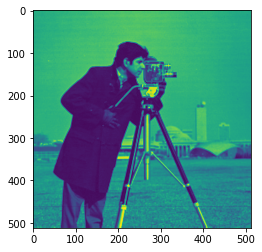

Normalized Image Shape: (512, 512)


In [23]:
def load_image(image_path):
    
    image = mpimg.imread(image_path)
    
    # normalize
    norm_image = image.astype(float) / 255
    
    # plot the image
    plt.imshow(norm_image)
    plt.show()
    
    return norm_image

image = load_image('./Data/Cameraman.jpg')
print(f'Normalized Image Shape: {image.shape}')

## Secret Message

##### *Function to encode the secret message and convert it to binary*

In [24]:
# define the message we want to encode in the picture
secret_message = 'secret'

def message_conversion(secret_message):
    
    # display secret message
    print(f'Secret message: {secret_message}', end='\n\n')

    # convert the secret message to binary
    ascii_values = [ord(character) for character in secret_message]
    binary_message = ''.join([bin(asc)[2:].zfill(8) for asc in ascii_values])
    
    print(f'Binary message: {binary_message}', end='\n\n')

    # modify the binary message to 1 and -1
    modified_message = np.array([int(char) if char == '1' else -1 for char in binary_message])
    print(f'Modified binary message: {"".join(str(x) for x in list(modified_message))}', end='\n\n')
    
    return modified_message

# execute
binary_message = message_conversion(secret_message)

Secret message: secret

Binary message: 011100110110010101100011011100100110010101110100

Modified binary message: -1111-1-111-111-1-11-11-111-1-1-111-1111-1-11-1-111-1-11-11-1111-11-1-1



##### *Calculate secret message and image sizes*

In [25]:
 # total bytes to be encoded in the image
bytes_num = len(binary_message)
print(f'Bytes to be encrypted: {bytes_num}')

# total bytes available for encoding
pixels_num = image.shape[0] * image.shape[1]
print(f'Bytes available for encryption: {pixels_num}')

Bytes to be encrypted: 48
Bytes available for encryption: 262144


## Random Matrix D

##### *Generate a random matrix D and its pseudoinverse*

In [26]:
def generate_D_matrix(bytes_num, pixels_num):
    
    # dimensions of random matrix D
    k = bytes_num
    n = pixels_num
    
    # generate random matrix D
    np.random.seed(123)
    D = np.random.randn(k,n)
    
    # normalize D
    print(f'The norm of matrix D is {int(np.linalg.norm(D))}.')
    D_norm = D / np.linalg.norm(D)
    print('Normalized Matrix D norm now is: {:.4f}' .format(np.linalg.norm(D_norm)), end='\n\n')
    
    # compute the moore penrose pseudoinverse matrix of D
    D_inv = np.linalg.pinv(D_norm)
    
    # shapes
    print(f'Normalized D Shape:  {np.shape(D_norm)}')
    print(f'Pseudoinverse D Shape: {np.shape(D_inv)}')
    
    return D_norm, D_inv

# execute
D_norm, D_inv = generate_D_matrix(bytes_num, pixels_num)

The norm of matrix D is 3547.
Normalized Matrix D norm now is: 1.0000

Normalized D Shape:  (48, 262144)
Pseudoinverse D Shape: (262144, 48)


## Solutions

*(a) - Encoding via least norm.*<br>We need to minimize $\|z\|^{2}$ subject to the equality constraint $D(x+z)=\alpha s$, which we can write as $Dz=\alpha s-Dx$. This is a least norm problem, with solution (assuming that $D$ has linearly independent rows) $z=D^{†}(\alpha s-Dx)$.

*(b) - Complexity.*<br>

    For encoding we have:
        Dx = 2kn flops
        as - Dx = k flops                        => Complexity = 4kn flops
        (D^+)(as - Dx) = 2kn flops               => Computation Time = 4*48*512^2 / 1000000000 = 0.050331648 sec

We can remove the subtraction since it is relativelly small compared to the others (n >> k).

    For decoding we have:
        D(x + z) = 2kn flops                     => Complexity = 2kn flops
                                                 => Computation Time = 2*48*512^2 / 1000000000 = 0.025165824 sec    
                                                 
*(c) - Try it out.*<br>In our example, we use a $512\times512$ image and a message of length $k=48$. The matrix $D$ is generated randomly and normalized to have norm $\|D\|=1$. The figures below show the original and the image with the message encoded for $10$ values of $\alpha$. For the first five values of $\alpha$ the message was decoded correctly. For $\alpha=10^{-5}$, the number of incorrectly decoded entries are $14$;  and for the rest values of $\alpha$, the number of incorrectly decoded entries are $17$.

##### *Trials for different values of alpha*

In [27]:
# function to measure the accuracy of the decoded message
def measure_decoding_accuracy(message, decoded_message):
    # calculate diff
    diff = message - decoded_message
    corr_answers = list(diff).count(0)
    wrng_answers = len(message) - corr_answers
    
    # accuracy
    accuracy = accuracy_score(message, decoded_message)
    
    return corr_answers, wrng_answers, accuracy

# function to convert the binary decoded message to string
def convert_decoded_message_to_text(message):
    # convert decoded message from -1 and 1 to 0 and 1
    actual_message = np.where(message == -1, 0, 1)
    # convert the array of zeros and ones into a string of zeros and ones
    actual_message = ''.join(list(str(x) for x in actual_message))
    # convert the string of zeros and ones into text
    actual_message = ''.join(chr(int(actual_message[i*8:i*8+8],2)) for i in range(len(actual_message)//8))
    # decoding UTF-8
    actual_message = actual_message.encode('utf-8').decode('utf-8')
    return actual_message

# function to plot the original and the modified image
def plot_images(image, modified_image):
    # create figure
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6),dpi=100,facecolor='white')
    # plot original image
    ax1.imshow(image)
    ax1.set_title('Original Image')        
    # plot modified image
    ax2.imshow(modified_image)
    ax2.set_title(f'a = {alpha}')        
    plt.tight_layout(pad=3)
    plt.show()
    return


# alpha = 1
************************************************************************************************************************
Decoded message: secret
------------------------------------------------------------------------------------------------------------------------
Correct estimates: 48
Wrong estimates:   0
Decoding accuracy: 100%
------------------------------------------------------------------------------------------------------------------------


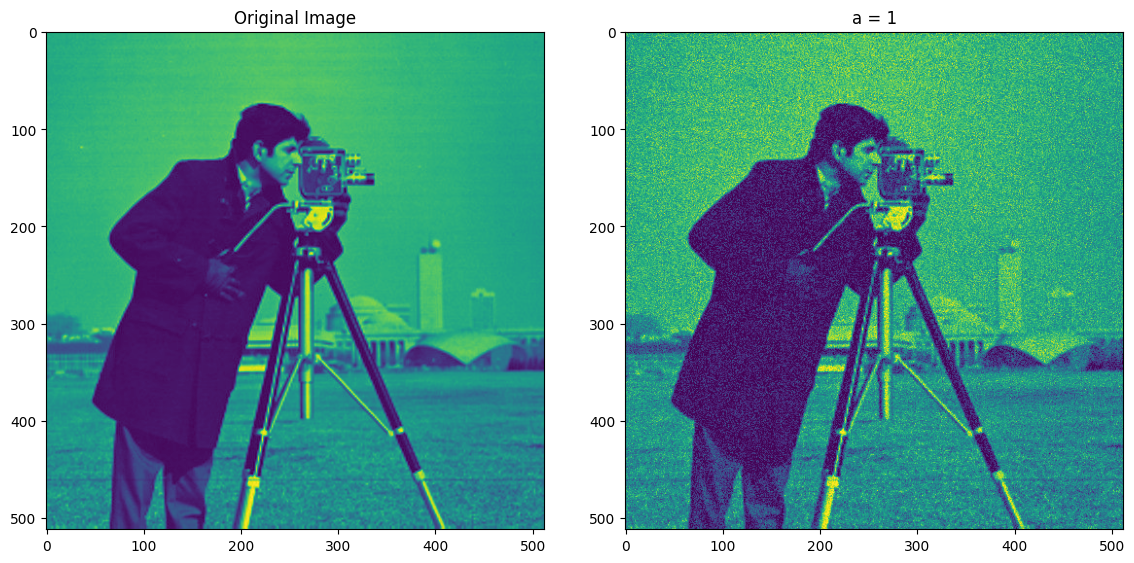


# alpha = 0.1
************************************************************************************************************************
Decoded message: secret
------------------------------------------------------------------------------------------------------------------------
Correct estimates: 48
Wrong estimates:   0
Decoding accuracy: 100%
------------------------------------------------------------------------------------------------------------------------


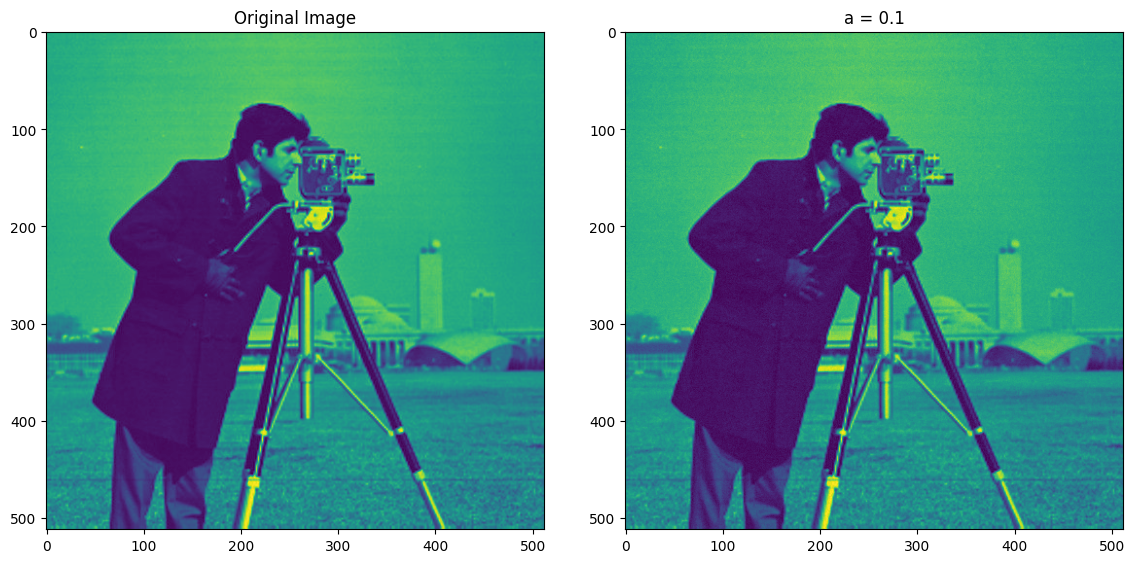


# alpha = 0.01
************************************************************************************************************************
Decoded message: secret
------------------------------------------------------------------------------------------------------------------------
Correct estimates: 48
Wrong estimates:   0
Decoding accuracy: 100%
------------------------------------------------------------------------------------------------------------------------


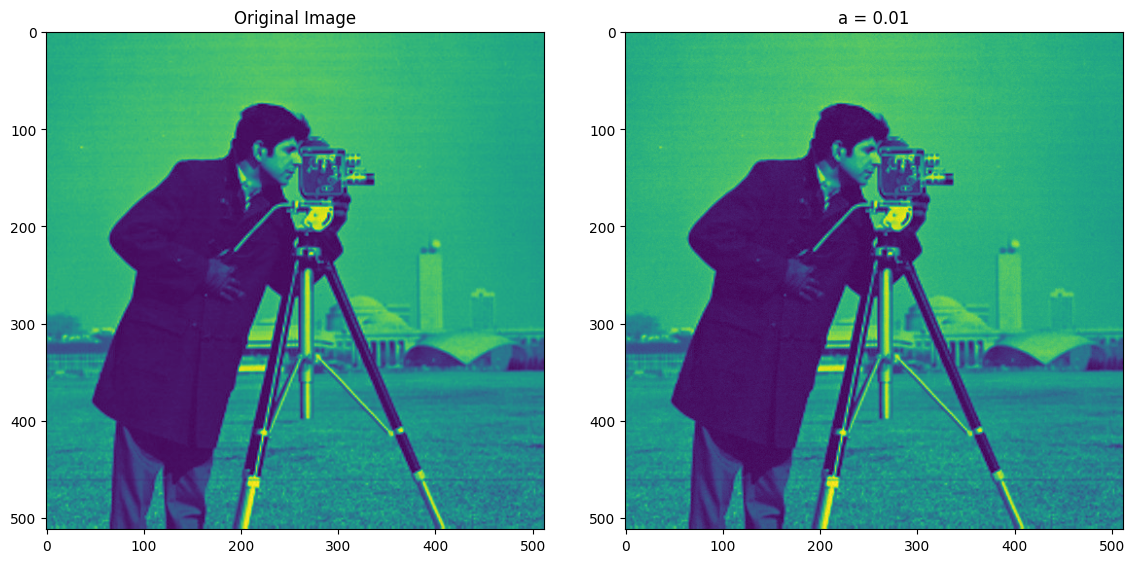


# alpha = 0.001
************************************************************************************************************************
Decoded message: secret
------------------------------------------------------------------------------------------------------------------------
Correct estimates: 48
Wrong estimates:   0
Decoding accuracy: 100%
------------------------------------------------------------------------------------------------------------------------


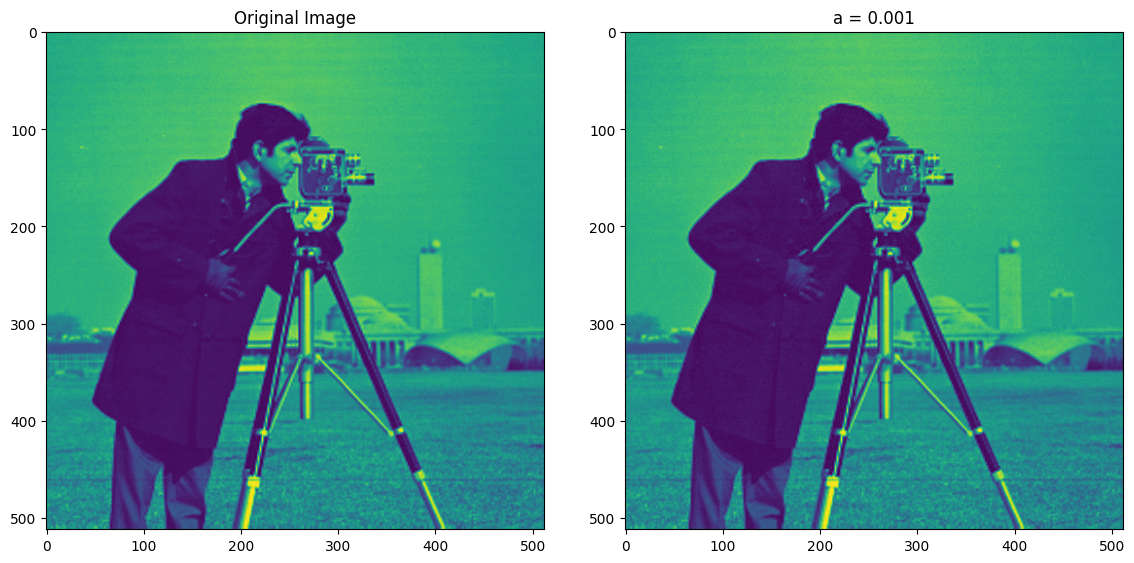


# alpha = 0.0001
************************************************************************************************************************
Decoded message: recRät
------------------------------------------------------------------------------------------------------------------------
Correct estimates: 44
Wrong estimates:   4
Decoding accuracy: 91%
------------------------------------------------------------------------------------------------------------------------


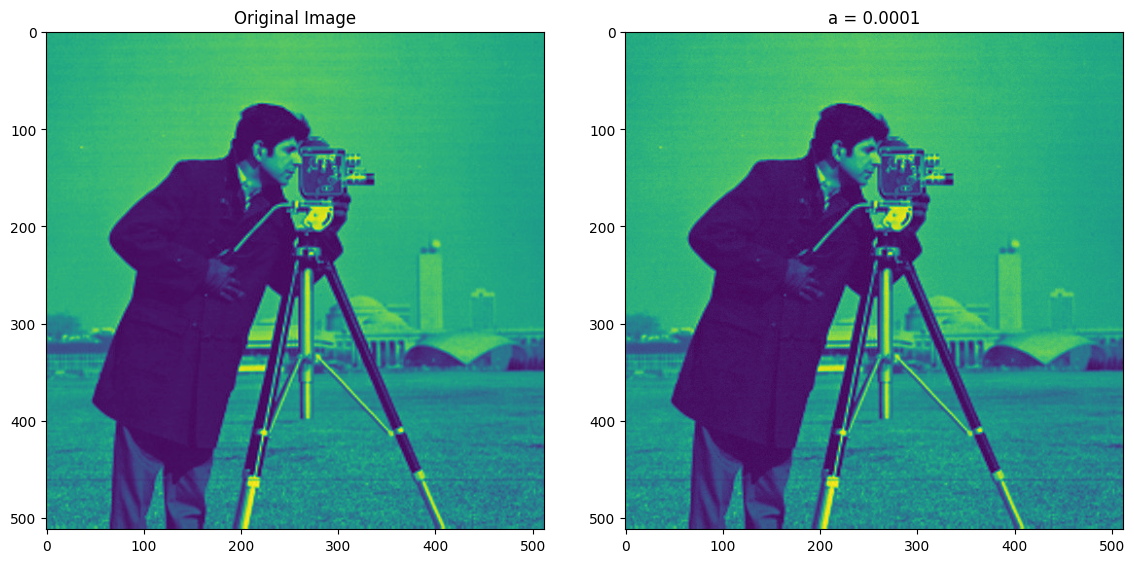


# alpha = 1e-05
************************************************************************************************************************
Decoded message: ýèC°6
------------------------------------------------------------------------------------------------------------------------
Correct estimates: 26
Wrong estimates:   22
Decoding accuracy: 54%
------------------------------------------------------------------------------------------------------------------------


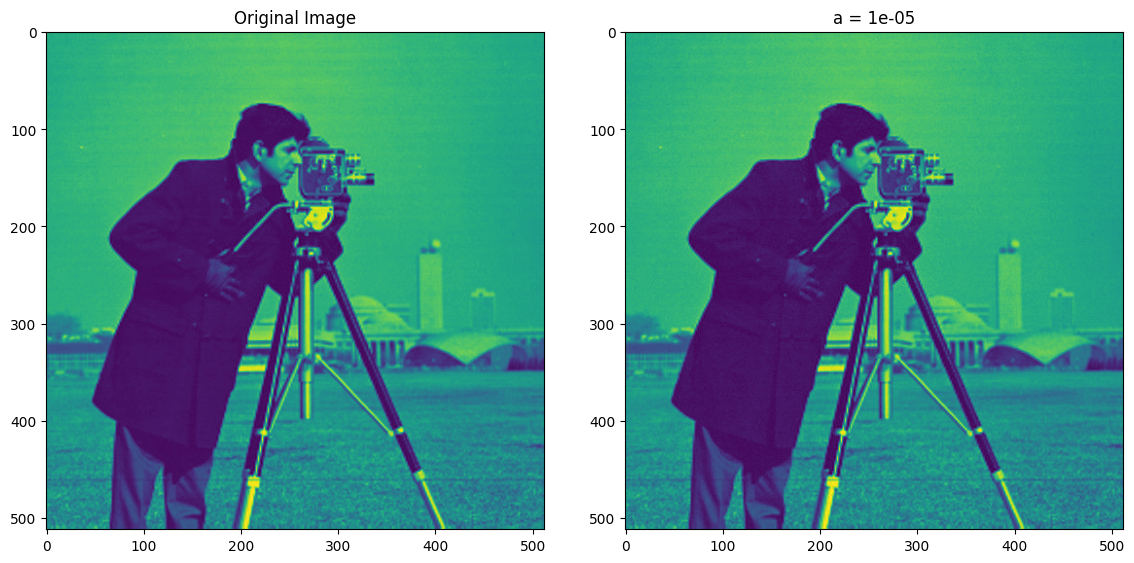


# alpha = 1e-06
************************************************************************************************************************
Decoded message: üèK°;
------------------------------------------------------------------------------------------------------------------------
Correct estimates: 21
Wrong estimates:   27
Decoding accuracy: 43%
------------------------------------------------------------------------------------------------------------------------


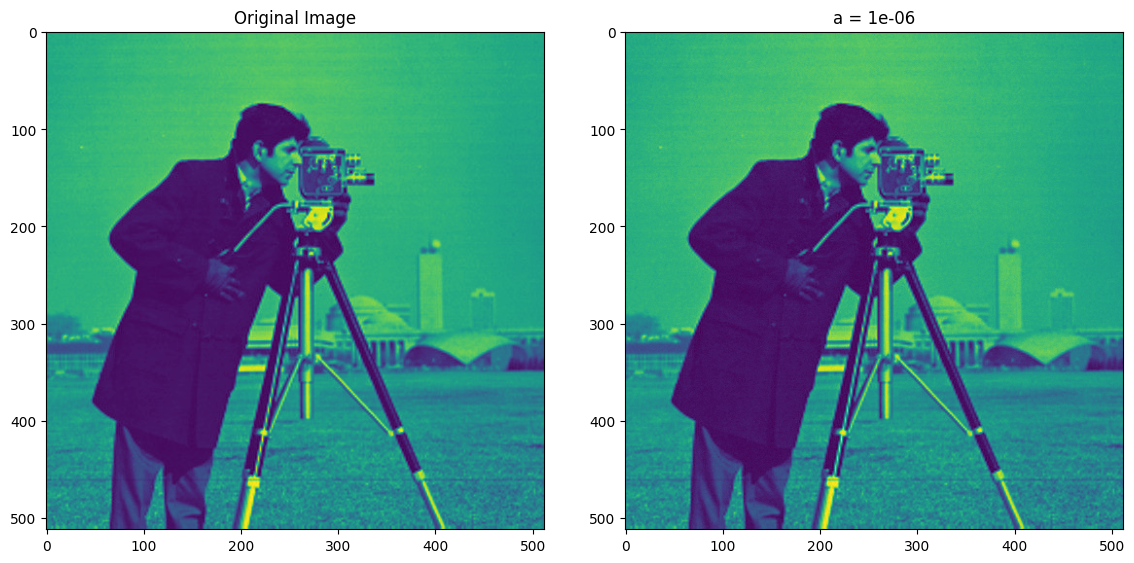


# alpha = 1e-07
************************************************************************************************************************
Decoded message: üèK°;
------------------------------------------------------------------------------------------------------------------------
Correct estimates: 21
Wrong estimates:   27
Decoding accuracy: 43%
------------------------------------------------------------------------------------------------------------------------


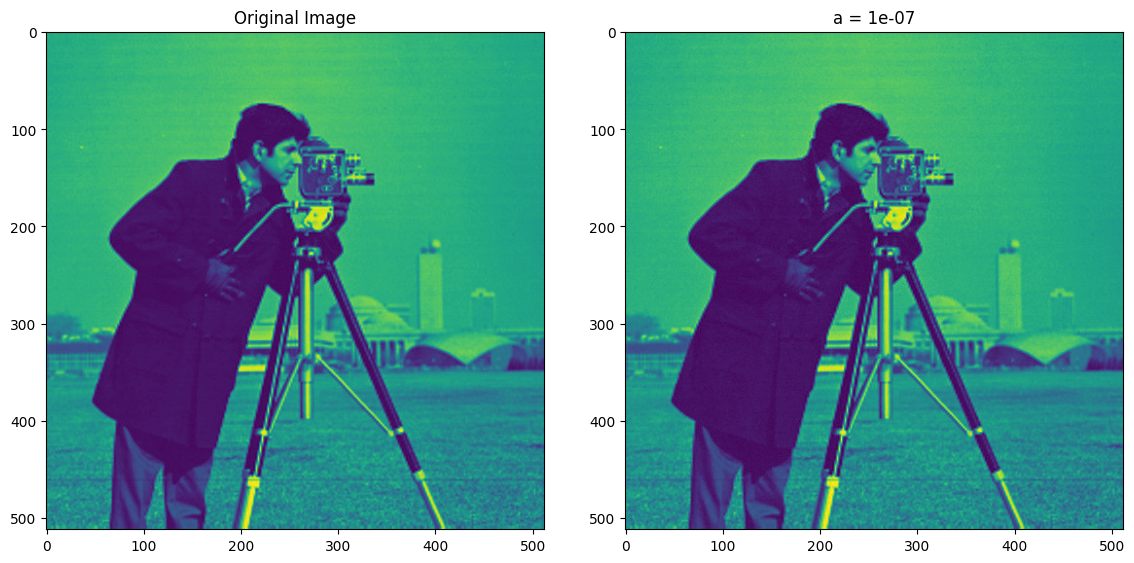

In [28]:
def alpha_trials(image, binary_message, D_norm, D_cross, alpha):
    
    # reshape image from a (x,y) matrix to a (x*y,) vector
    x = image.flatten()
    
    # encoding via least norm
    # compute z, the n-vector of modifications
    z = np.dot(D_cross, (alpha * binary_message - np.dot(D_norm, x)))
    
    # reshape modifications from a (x*y,) vector to a (x,y) matrix
    z_image_mods = np.reshape(z, (image.shape[0], image.shape[1]))
    
    # modify the initial image
    x_z_image = image + z_image_mods
    
    # replace any negative values with zero
    # and any values greater than one with one
    x_z_image = np.where(x_z_image > 1, 1, np.where(x_z_image < 0, 0, x_z_image))
    
    # reshape the modified image from a (x,y) matrix to a (x*y,) vector
    x_z_image_vector = x_z_image.flatten()
    
    # decompose the image, get the decoded message estimates
    decoded_message_est = np.dot(x_z_image_vector, D_norm.T)
    
    # get the binary decoded message
    binary_decoded_message = np.sign(decoded_message_est).astype(int)
    
    # execute the function
    corr_answers, wrng_answers, accuracy = measure_decoding_accuracy(binary_message, binary_decoded_message)
        
    # execute the function
    text_decoded_message = convert_decoded_message_to_text(binary_decoded_message)
    
    # print results
    print('\n' + f'# alpha = {alpha}')
    print('*'*120)
    print(f'Decoded message: {text_decoded_message}')
    print('-'*120)
    print(f'Correct estimates: {corr_answers}')
    print(f'Wrong estimates:   {wrng_answers}')
    print(f'Decoding accuracy: {int(accuracy*100)}%')
    print('-'*120)
    
    # plot images
    _ = plot_images(image, x_z_image)
    
    return

# create list of alphas to test
alphas = [10**(-i) for i in range(8)]

# loop through alphas
for alpha in alphas:
    _ = alpha_trials(image, binary_message, D_norm, D_inv, alpha)

## Remarks

The level of noise introduced to the image increases with a higher alpha value. Adding more noise to the image enhances the clarity of encoding and decoding a hidden message. In this experiment, the word "secret" was chosen as the concealed message. Various alpha values were tested for encoding and decoding the message. The investigation revealed that the optimal alpha value, where the secret message could be encoded and decoded without introducing noise while maintaining a nearly identical appearance to the original image, was $0.001$. At this alpha value, the decoding accuracy reached $100\%$, with the model accurately estimating and decoding all $48$ bytes of the secret message.